In [1]:
import ecrlcesm.environment
import ecrlgcm.preprocessing as pp
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy.ndimage as nd
from ecrlgcm.experiment import Experiment
from ecrlgcm.postprocessing import get_interactive_globe
from ecrlgcm.postprocessing import get_hires_topo_and_polar_coords, get_field_and_polar_coords, define_noaa_colormap, define_cloud_colormap, field_interp
from ecrlgcm.postprocessing import variable_dictionary
import matplotlib
import plotly.io as pio
pio.renderers.default = 'iframe'
import time
from metpy.calc import smooth_n_point
from perlin_noise import PerlinNoise
from tqdm import tqdm
import cv2 as cv
import PIL
#from matplotlib.ticker import LinearLocator,FormatStrFormatter
#from tqdm import tqdm
#import IPython

#%matplotlib notebook
#%matplotlib widget

In [9]:
def c_function(lat,lon,lat_orig=0,lon_orig=0,radius=20,thickness=4):
    if lon < 0: lon+=360.0
    if lon_orig < 0: lon_orig+=360.0
    if lon < lon_orig:
        if (radius-thickness/2)**2 <= (lat-lat_orig)**2+(lon-lon_orig)**2 <= (radius+thickness/2)**2:
            return True
    return False

def i_function(lat,lon,lat_orig=0,lon_orig=0,height=40,thickness=4):
    if lon < 0: lon+=360.0
    if lon_orig < 0: lon_orig+=360.0
    if ((lon_orig-thickness/2) <= lon <= (lon_orig+thickness/2) and
        (lat_orig-height/2) <= lat <= (lat_orig+height/2)):
        return True
    return False

def s_function(lat,lon,lat_orig=0,lon_orig=0,height=40,amplitude=10,thickness=4):
    if lon < 0: lon+=360.0
    if lon_orig < 0: lon_orig+=360.0
    if ((lat_orig-height/2) <= lat <= (lat_orig+height/2) and
        ((-amplitude*np.sin(2*np.pi/height*(lat-lat_orig))-(thickness+1)/2+lon_orig) <= lon <= (-amplitude*np.sin(2*np.pi/height*(lat-lat_orig))+(thickness+1)/2+lon_orig))):
        return True
    return False

In [10]:
def get_noise(lats,lons,amplitude):
    pic = np.zeros((len(lats),len(lons)))
    xpix, ypix = len(lons), len(lats)
    noise1 = PerlinNoise(octaves=3)
    noise2 = PerlinNoise(octaves=6)
    noise3 = PerlinNoise(octaves=12)
    noise4 = PerlinNoise(octaves=24)

    for i in tqdm(range(xpix)):
        for j in range(ypix):
            lat = lats[j]
            lon = lons[i]
            if lon<0: lon+=360.0
            if (-30 <= lat <= 30 and 
                150 <= lon <= 250):
                noise_val = amplitude*noise1([i/xpix, j/ypix])
                noise_val += 0.5*amplitude*noise2([i/xpix, j/ypix])
                noise_val += 0.25*amplitude*noise3([i/xpix, j/ypix])
                noise_val += 0.15*amplitude*noise4([i/xpix, j/ypix])

                pic[j,i] = noise_val
    return (pic-np.min(pic))    

In [11]:
def etch_letters(letters,lats,lons,lon_orig=100,lat_orig=20,radius=25,height=55,amplitude=10,spacing=20,thickness=4,pic=None):
    
    for lat_idx in tqdm(range(len(lats))):
        for lon_idx in range(len(lons)):
            lat = lats[lat_idx]
            lon = lons[lon_idx]
            if c_function(lat,lon,lon_orig=lon_orig,lat_orig=lat_orig,radius=radius,thickness=thickness):
                letters[lat_idx,lon_idx]=pic[lat_idx,lon_idx]
            if s_function(lat,lon,lon_orig=lon_orig+0.8*spacing,lat_orig=lat_orig,height=height,amplitude=amplitude,thickness=thickness):    
                letters[lat_idx,lon_idx]=pic[lat_idx,lon_idx]
            if i_function(lat,lon,lon_orig=(lon_orig+1.8*spacing),lat_orig=lat_orig,height=height,thickness=thickness):
                letters[lat_idx,lon_idx]=pic[lat_idx,lon_idx]
    return letters            

In [12]:
def combine_land(data,csi):
    land = data['z'].values
    for i in tqdm(range(csi.shape[0])):
        for j in range(csi.shape[1]):
            if csi[i,j] != 0:
                land[i,j] = csi[i,j]
    return land   

In [ ]:
data = xr.open_mfdataset('/data/bnb32/inputdata/paleodem_raw/Map43_PALEOMAP_6min_Late_Triassic_200Ma.nc')
land = data['z'].values
lats = data['latitude'].values
lons = data['longitude'].values
pic = get_noise(lats,lons,4000)
land = np.full(land.shape,0.0)
land = smooth_n_point(etch_letters(land,lats,lons,lon_orig=175,lat_orig=0,radius=20.0,height=50,amplitude=12,spacing=37,thickness=9,pic=pic))
land = combine_land(data,smooth_n_point(land,5))

 13%|████████▉                                                           | 470/3601 [02:48<12:39,  4.12it/s]

In [145]:
data['z'] = (data['z'].dims,land)
data.to_netcdf('/data/bnb32/inputdata/paleodem_raw/Map89_751Ma.nc')

In [20]:
exp = Experiment(land_year=200)
data = exp.base()#xr.open_mfdataset('/data/bnb32/inputdata/paleodem_raw/Map43_PALEOMAP_6min_Late_Triassic_200Ma.nc')
land = data['z'].values
lats = data['lat'].values
lons = data['lon'].values
pic = get_noise(lats,lons,4000)
land = np.full(land.shape,0.0)
land = smooth_n_point(etch_letters(land,lats,lons,lon_orig=172,lat_orig=0,radius=20.0,height=50,amplitude=12,spacing=37,thickness=9,pic=pic))
land = combine_land(data,smooth_n_point(land,5))

100%|██████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 384.28it/s]


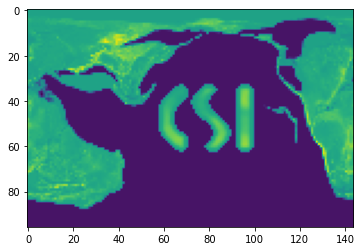

In [21]:
plt.imshow(land[::-1])

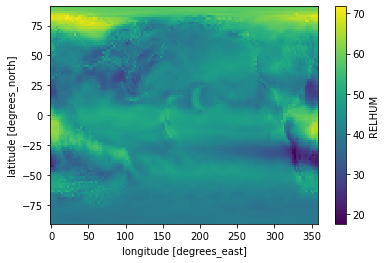

In [7]:
Experiment(land_year=751).run_data()['RELHUM'].mean(axis=(0,1)).plot.imshow()

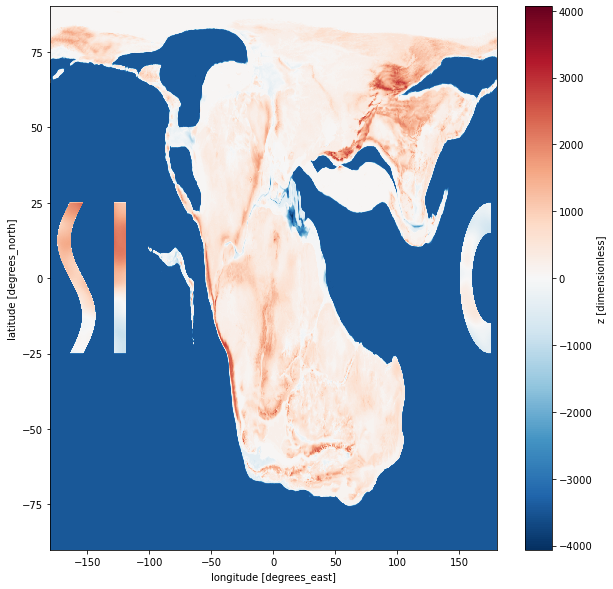

In [109]:
fig = plt.figure(figsize=(10,10))
data['z'].plot.imshow(extent=[180,-180,-90,90])
plt.show()

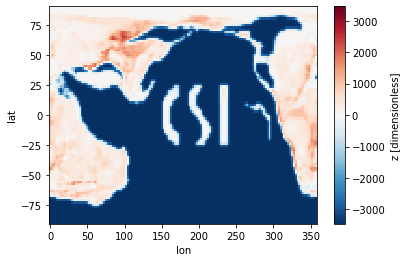

In [4]:
tmp = xr.open_mfdataset('/data/bnb32/inputdata/topo_files/high_res/751Ma_high_res.nc')

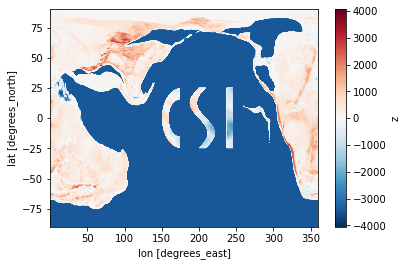

In [5]:
tmp['z'].plot.imshow()

In [15]:
exp = Experiment(land_year=751)

In [17]:
tmp = exp.run_data()

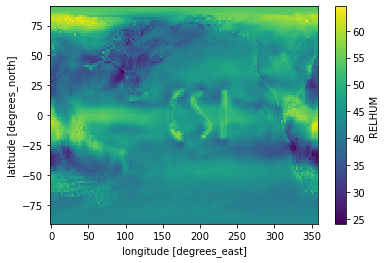

In [22]:
tmp['RELHUM'].mean(axis=(0,1)).plot.imshow()

In [389]:
data['z'] = (data['z'].dims,land)

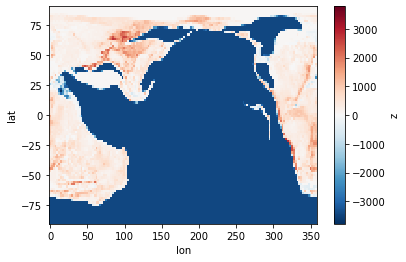

In [377]:
exp.base()['z'].plot.imshow()

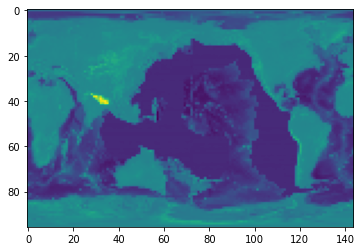

In [24]:
plt.imshow(Experiment(land_year=40).base()['z'].values[::-1])

In [68]:
variable_dictionary = {}
data = Experiment(land_year=0).sim_data()
for e in list(data):
    if 'lat' in data[e].dims and 'lon' in data[e].dims:
        try:
            variable_dictionary[e] = data[e].long_name
        except:
            pass

In [70]:
data['T'].dims

('time', 'lev', 'lat', 'lon')

In [31]:
variable_dictionary['RELHUM']

'Relative humidity'

In [2]:
fig = get_interactive_globe(fast=True)
fig.update_layout(width=1000,height=700)
start_time = time.time()
fig.show()
print(time.time()-start_time)

[INFO] 2021-11-07 18:09:32,229 Prep time: 0.4695310592651367
[INFO] 2021-11-07 18:09:32,900 Plotting time: 0.6700601577758789


1.9869675636291504


In [1]:
import plotly.graph_objects as go # or plotly.express as px
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from ecrlgcm.postprocessing import get_interactive_globe

dropdown_options = []
for k,v in variable_dictionary.items():
    dropdown_options.append({'label':v,'value':k})

app = dash.Dash(__name__)
server = app.server

app.layout = html.Div([html.H6('Paleoclimate Modeling',style={'width':'100%', 'textAlign': 'center','font-size': '25px',"padding-top": "1px"}), 
    html.Label(["Year (in Ma BP): "],style={'display': 'inline-block','textAlign':'center','font-size':'20px'}),
    html.Div([
        dcc.Slider(
        id='land_year',
        min=0,
        max=500,
        step=10,
        value=0,
        tooltip={"placement": "bottom", "always_visible": True}
    )]),
    html.Br(),
    html.Label(["Pressure Level: "],style={'display': 'inline-block','textAlign':'center','font-size':'20px','padding-left':'20px'}),
    html.Div([
        dcc.Slider(
        id='plevel',
        min=0,
        max=1000,
        step=10,
        value=850,
        tooltip={"placement": "bottom", "always_visible": True})]),
    html.Br(),                   
    html.Label(["Fields: "],style={'display': 'inline-block','textAlign':'center','padding-top':'15px','font-size':'20px'}),
    html.Div([

    dcc.Dropdown(id='field',
    options=dropdown_options,
    value='RELHUM',
    multi=False)],
    style={'width': '30%', 'display': 'inline-block','textAlign':'left','height':'21px','font-size':'18px','padding-left':'10px'}),
    html.Br(),
    html.Div([dcc.Graph(id='my-output')],style={'width':'90%','textAlign': 'center','padding-top':'20px'}),

],style={"width": "1000px",
         "height": "900px",
         "display": "inline-block",
         "border": "3px #5c5c5c solid",
         "padding-top": "1px",
         "padding-left": "0px",
         "overflow": "hidden",
         'textAlign':'center'})


@app.callback(
    Output(component_id='my-output', component_property='figure'),
    [Input(component_id='land_year', component_property='value'),
     Input(component_id='plevel', component_property='value'),
     Input(component_id='field', component_property='value')]
)
def update_output_div(land_year,plevel,field):
    try:
        land_year = float(land_year)
        fig = get_interactive_globe(land_year=land_year,
                                    field=field,
                                    plevel=plevel,
                                    fast=True)
        start_time = time.time()
        fig.update_layout(width=1000,height=520)
        print(f'update time: {time.time()-start_time}')
    except:
        fig = get_interactive_globe(fast=True)
        fig.update_layout(width=1000,height=520)
        
    return fig


#if __name__ == '__main__':
#    app.run_server(debug=True)


app.run_server(debug=True, use_reloader=False)

NameError: name 'variable_dictionary' is not defined

In [7]:
define_noaa_colormap()
define_cloud_colormap()

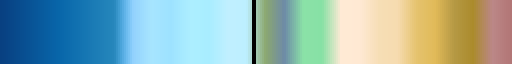

In [8]:
plt.get_cmap('custom_noaa')

In [4]:
fig = get_interactive_globe(save_fig=False,plevel=850,field='rh',gcm_type='isca',vmin=0,vmax=100)

In [5]:
fig.show()

In [3]:
topo,x,y,z = get_hires_topo_and_polar_coords(0)
field_array,xf,yf,zf = get_field_and_polar_coords(0,'RELHUM')
my_cols = plt.get_cmap('custom_noaa')((topo+10000)/20000)
field_cols = plt.get_cmap('custom_clouds')(field_array.values/100)
#my_cols = plt.get_cmap('custom_noaa')((topo))
'''
minima = topo.min()
maxima = topo.max()
norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='custom_noaa')
colors = np.zeros(topo.shape,dtype=object)

for i in tqdm(range(topo.shape[0])):
    for j in range(topo.shape[1]):
        colors[i,j] = mapper.to_rgba(topo[i,j])
'''        

"\nminima = topo.min()\nmaxima = topo.max()\nnorm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)\nmapper = cm.ScalarMappable(norm=norm, cmap='custom_noaa')\ncolors = np.zeros(topo.shape,dtype=object)\n\nfor i in tqdm(range(topo.shape[0])):\n    for j in range(topo.shape[1]):\n        colors[i,j] = mapper.to_rgba(topo[i,j])\n"

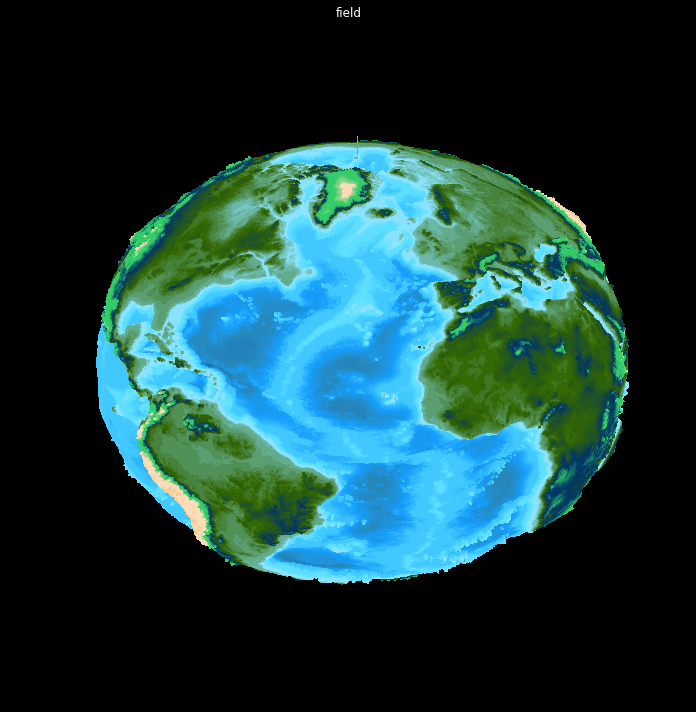

In [7]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(10,10),facecolor='black')
ax.set_title('field', color='white')

# Plot the surface.
surf = ax.plot_surface(np.array(x),np.array(y),np.array(z), cmap='custom_noaa',
                       facecolors=my_cols,linewidth=0.0, antialiased=False,
                       rstride=1,cstride=1,alpha=1)
#field_surf = ax.plot_surface(np.array(xf),np.array(yf),np.array(zf), cmap='custom_clouds',
#                       facecolors=field_cols,linewidth=0.0, antialiased=False,
#                       rstride=1,cstride=1,alpha=0.2)
ax.set_axis_off()
ax.mouse_init()
ax.view_init(20, 330)
ax.dist = 7
ax.set_facecolor('black')

# Customize the z axis.
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# Add a color bar which maps values to colors.
#cbar = fig.colorbar(surf,ticks=[0, 0.5, 1],shrink=0.5)#,orientation='horizontal')
#cbar = fig.colorbar(field_surf,shrink=0.5)
#cbar.set_label(f'field', color='white')
#cbar.ax.yaxis.set_tick_params(color='white')
#plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')
#cbar.ax.set_yticklabels(['-10000', '0', '10000'])
plt.tight_layout()
#plt.colorbar(surf)
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

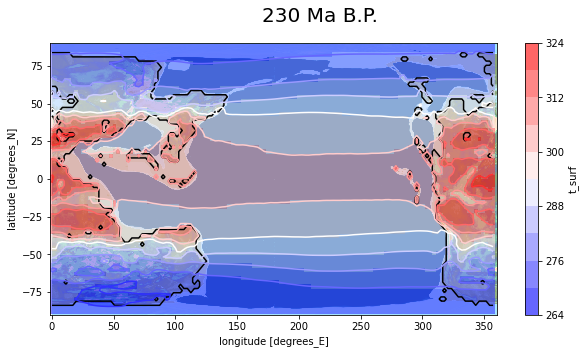

In [7]:
fig = plt.figure(figsize=(10,5))
fig.suptitle('230 Ma B.P.',fontsize=20)
Experiment(gcm_type='isca',land_year=230).hires()['z'].plot.imshow(cmap='custom_noaa',add_colorbar=False)
Experiment(gcm_type='isca',land_year=230).base()['land_mask'].plot.contour(levels=1,colors='black',add_colorbar=False)
Experiment(gcm_type='isca',land_year=230).sim_data()['t_surf'].mean(axis=(0)).plot.imshow(levels=10,cmap='bwr',alpha=0.6)
Experiment(gcm_type='isca',land_year=230).sim_data()['t_surf'].mean(axis=(0)).plot.contour(levels=10,cmap='bwr',alpha=1)

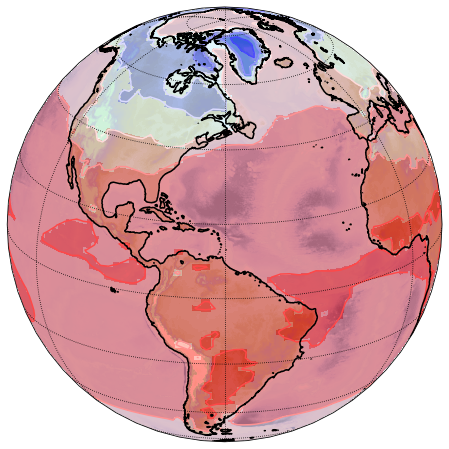

In [58]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

exp = Experiment(gcm_type='isca',land_year=0)
exp = Experiment(gcm_type='cesm',land_year=0.02)
extent = (0,360,-90,90)

plt.figure(figsize=(8, 8))
proj = ccrs.Orthographic(300, 20)
ax = plt.axes(projection=proj)
ax.gridlines(color='black', linestyle='dotted')
exp.hires()['z'].plot.imshow(origin="upper", extent=extent,
          transform=ccrs.PlateCarree(), cmap='custom_noaa',add_colorbar=False,interpolation='bilinear')
exp.sim_data()['TS'].mean(axis=0).plot.imshow(origin="upper", extent=extent,
          transform=ccrs.PlateCarree(), cmap='bwr',alpha=0.6,add_colorbar=False,interpolation='bilinear',levels=10)
exp.sim_data()['TS'].mean(axis=0).plot.contour(origin="upper", extent=extent,
          transform=ccrs.PlateCarree(), cmap='bwr',alpha=1,add_colorbar=False,levels=10)
exp.hires()['landmask'].plot.contour(origin="upper", extent=extent,
          transform=ccrs.PlateCarree(), colors='black',alpha=1.0,add_colorbar=False,levels=1)

plt.show()

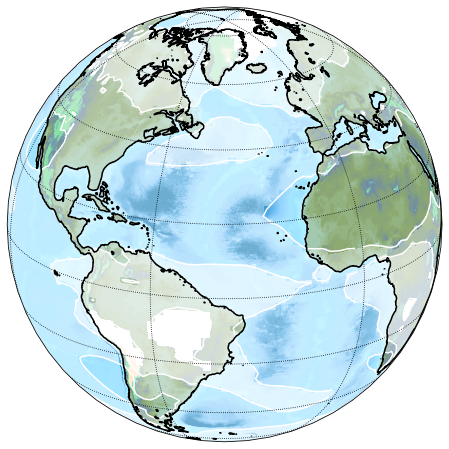

In [51]:
exp = Experiment(gcm_type='isca',land_year=0)
exp = Experiment(gcm_type='cesm',land_year=0.02)
extent = (0,360,-90,90)

plt.figure(figsize=(8, 8))

ax = plt.axes(projection=ccrs.Orthographic(320, 20))
ax.gridlines(color='black', linestyle='dotted')
exp.hires()['z'].plot.imshow(origin="upper", 
                             #extent=extent,
          transform=ccrs.PlateCarree(), cmap='custom_noaa',add_colorbar=False,interpolation='bilinear')
exp.sim_data()['RELHUM'].mean(axis=(0,1)).plot.imshow(origin="upper", 
                                                      #extent=extent,
          transform=ccrs.PlateCarree(), cmap='custom_clouds',alpha=1.0,add_colorbar=False,interpolation='bilinear',levels=6)
exp.sim_data()['RELHUM'].mean(axis=(0,1)).plot.contour(origin="upper", 
                                                       #extent=extent,
          transform=ccrs.PlateCarree(), cmap='custom_clouds',alpha=1,add_colorbar=False,levels=6)
exp.hires()['landmask'].plot.contour(origin="upper", 
                                     #extent=extent,
          transform=ccrs.PlateCarree(), colors='black',alpha=1.0,add_colorbar=False,levels=1)

plt.show()

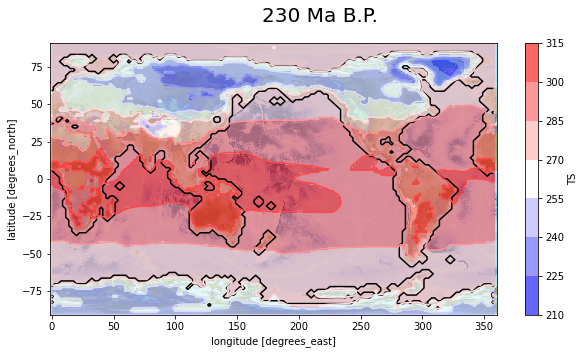

In [42]:
fig = plt.figure(figsize=(10,5))
fig.suptitle('230 Ma B.P.',fontsize=20)
exp = Experiment(land_year=0.02)
exp.hires()['z'].plot.imshow(cmap='custom_noaa',add_colorbar=False)
exp.base()['landmask'].plot.contour(levels=1,colors='black',add_colorbar=False)
exp.sim_data()['TS'].mean(axis=0).plot.imshow(levels=10,cmap='bwr',alpha=0.6)
exp.sim_data()['TS'].mean(axis=0).plot.contour(levels=10,cmap='bwr',alpha=1)

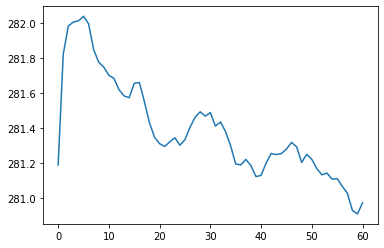

In [8]:
plt.plot(Experiment(land_year=230).sim_data()['TS'].mean(axis=(1,2)).values)


In [6]:
Experiment(land_year=3).sim_data()['TS'].mean(axis=(0,1,2)).values

array(281.86566, dtype=float32)

In [19]:
tmp = 'co2_hello.nc'
print(tmp.rstrip(".nc"))

co2_hello


In [2]:
stored_years = [0,0.02,3,5,10,55,65,100,230,500]

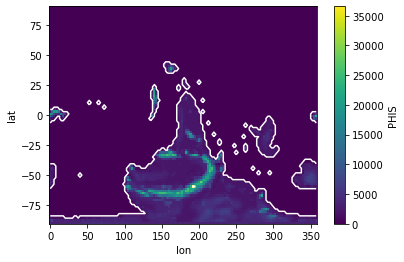

In [13]:
plt.figure()
field_interp(490,stored_years,None)['mask'].plot.contour(levels=2,colors=(1,1,1))
field_interp(490,stored_years,None)['PHIS'].plot.imshow()
plt.show()

In [12]:
plt.get_cmap('gray')(256)

(1.0, 1.0, 1.0, 1.0)

In [7]:
field_interp(90,stored_years,None)['frac'].values.min()

0.0

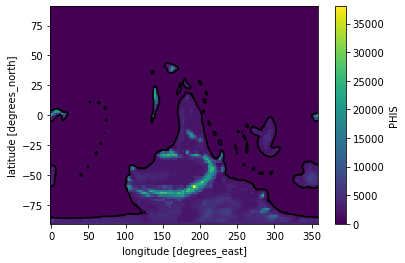

In [21]:
plt.figure()
Experiment(land_year=500).hires()['landmask'].plot.contour(levels=1,colors='black')
Experiment(land_year=500).topo()['PHIS'].plot.imshow()
plt.show()

In [4]:
Experiment(land_year=230).topo()['PHIS'].dims

('lat', 'lon')

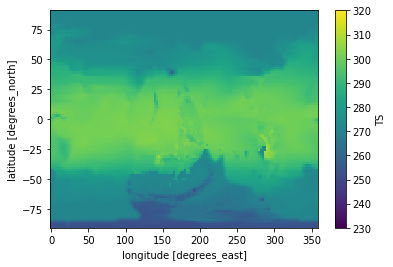

In [16]:
Experiment(land_year=500).sim_data()['TS'].mean(axis=0).plot.imshow(vmin=230,vmax=320)

In [19]:
Experiment(land_year=500).sim_data()['co2vmr'].mean(axis=0).values

array(0.00566757)

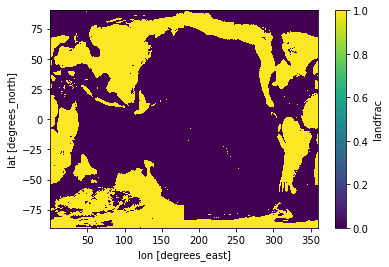

In [5]:
hires['landfrac'].plot.imshow()

In [9]:
data_50 = xr.open_mfdataset('/data/bnb32/scratch/archive/cam_clmCN_docnDOM_co2_1.0x_continents_50Ma_experiment/atm/hist/cam_clmCN_docnDOM_co2_1.0x_continents_50Ma_experiment.cam.h0.0001-01-01-00000.nc')

In [34]:
data_0 = xr.open_mfdataset('/data/bnb32/scratch/archive/cam_clmCN_docnDOM_co2_1.0x_continents_0Ma_experiment/atm/hist/cam_clmCN_docnDOM_co2_1.0x_continents_0Ma_experiment.cam.h0.0001-01-01-00000.nc')

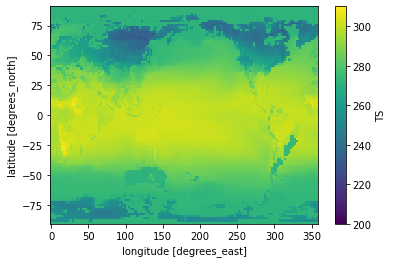

In [39]:
data_50['TS'].mean(axis=0).plot.imshow(vmin=200,vmax=310)

In [40]:
data_50['co2vmr'].values

array([0.00095309, 0.00095309, 0.00095309, 0.00095309, 0.00095309,
       0.00095309, 0.00095309, 0.00095309, 0.00095309, 0.00095309,
       0.00095309, 0.00095309, 0.00095309, 0.00095309, 0.00095309,
       0.00095309, 0.00095309, 0.00095309, 0.00095309, 0.00095309,
       0.00095309, 0.00095309, 0.00095309, 0.00095309, 0.00095309,
       0.00095309, 0.00095309, 0.00095309, 0.00095309, 0.00095309,
       0.00095309, 0.00095309, 0.00095309, 0.00095309, 0.00095309,
       0.00095309, 0.00095309, 0.00095309, 0.00095309, 0.00095309,
       0.00095309, 0.00095309, 0.00095309, 0.00095309, 0.00095309,
       0.00095309, 0.00095309, 0.00095309, 0.00095309, 0.00095309,
       0.00095309, 0.00095309, 0.00095309, 0.00095309, 0.00095309,
       0.00095309, 0.00095309, 0.00095309, 0.00095309, 0.00095309,
       0.00095309])

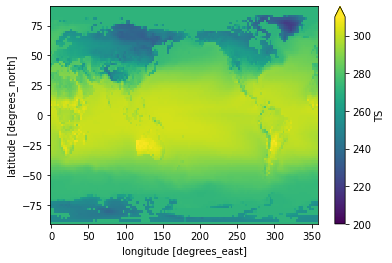

In [38]:
data_0['TS'].mean(axis=0).plot.imshow(vmin=200,vmax=310)

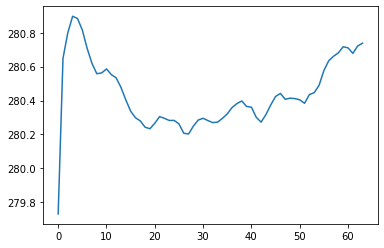

In [45]:
plt.plot(data_0['TS'].mean(axis=(1,2)))

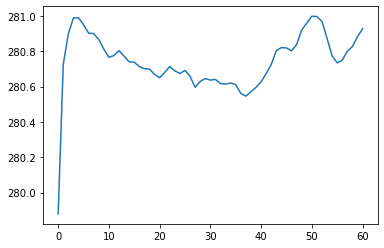

In [46]:
plt.plot(data_50['TS'].mean(axis=(1,2)))

In [41]:
data_0['co2vmr'].values

array([0.00029639, 0.00029639, 0.00029639, 0.00029639, 0.00029639,
       0.00029639, 0.00029639, 0.00029639, 0.00029639, 0.00029639,
       0.00029639, 0.00029639, 0.00029639, 0.00029639, 0.00029639,
       0.00029639, 0.00029639, 0.00029639, 0.00029639, 0.00029639,
       0.00029639, 0.00029639, 0.00029639, 0.00029639, 0.00029639,
       0.00029639, 0.00029639, 0.00029639, 0.00029639, 0.00029639,
       0.00029639, 0.00029639, 0.00029639, 0.00029639, 0.00029639,
       0.00029639, 0.00029639, 0.00029639, 0.00029639, 0.00029639,
       0.00029639, 0.00029639, 0.00029639, 0.00029639, 0.00029639,
       0.00029639, 0.00029639, 0.00029639, 0.00029639, 0.00029639,
       0.00029639, 0.00029639, 0.00029639, 0.00029639, 0.00029639,
       0.00029639, 0.00029639, 0.00029639, 0.00029639, 0.00029639,
       0.00029639, 0.00029639, 0.00029639, 0.00029639])

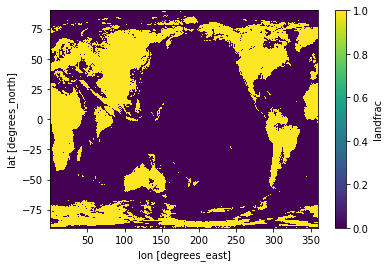

In [3]:
hires['landfrac'].plot.imshow()

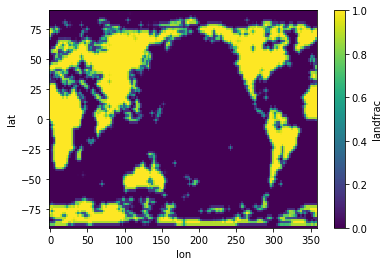

In [12]:
(f19_remap['landfrac']).plot.imshow()

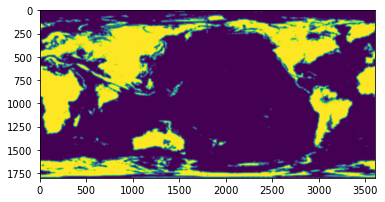

In [22]:
plt.imshow(nd.gaussian_filter(hires['landfrac'].values,5)[::-1])

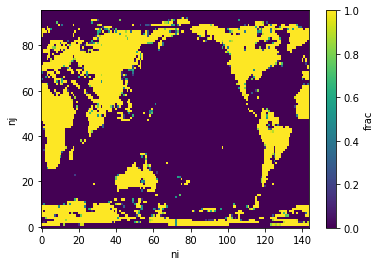

In [4]:
land['frac'].plot.imshow()

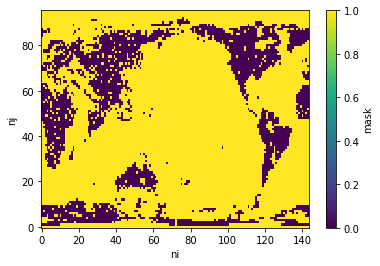

In [7]:
ocean['mask'].plot.imshow()

In [3]:
oceanfrac = (1-f19_remap['landfrac']).values
oceanfrac = np.where(oceanfrac>1,1,oceanfrac)
oceanfrac = np.where(oceanfrac<0.001,0,oceanfrac)

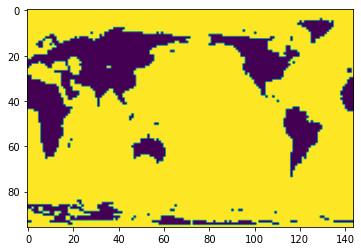

In [4]:
plt.imshow(np.array(oceanfrac>0.001,dtype=int)[::-1])

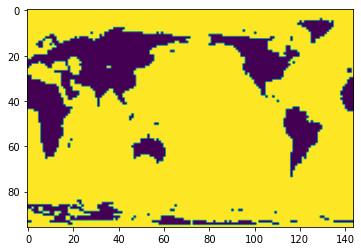

In [23]:
plt.imshow(np.where(oceanfrac>0.0,1,0)[::-1])

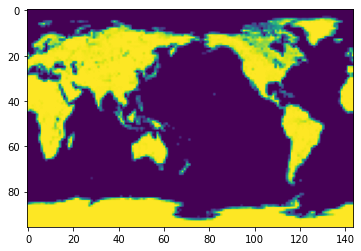

In [23]:
landfrac = land['frac'].values
landfrac = np.where(landfrac>0.001,landfrac,0.0)
plt.imshow(landfrac[::-1])

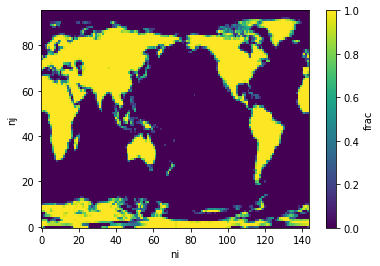

In [3]:
land['frac'].plot.imshow()

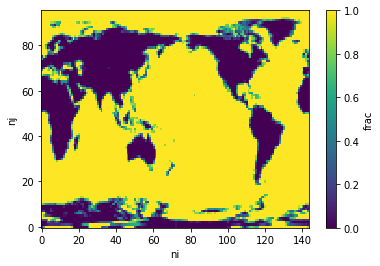

In [4]:
ocean['frac'].plot.imshow()

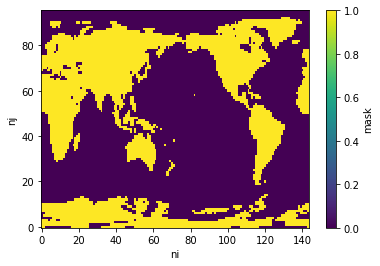

In [5]:
(land['mask']).plot.imshow()

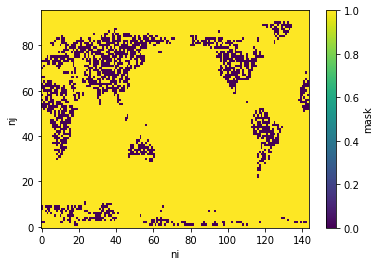

In [6]:
(ocean['mask']).plot.imshow()

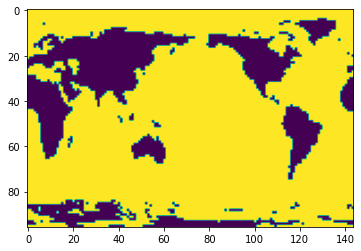

In [9]:
plt.imshow(np.array(ocean['frac'].values>0.1,dtype=int)[::-1])

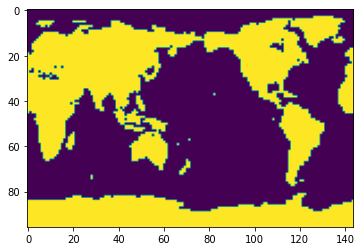

In [13]:
plt.imshow(np.array(land['frac'].values>0,dtype=int)[::-1])

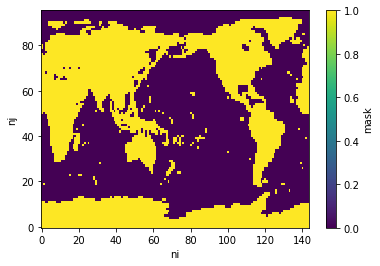

In [5]:
land['mask'].plot.imshow()

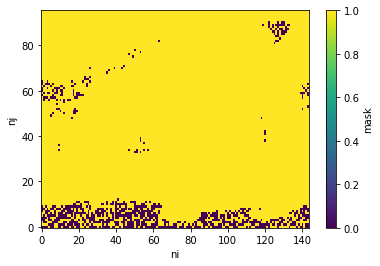

In [6]:
ocean['mask'].plot.imshow(vmin=0)

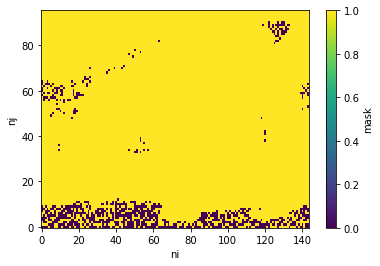

In [10]:
(ocean['mask']).plot.imshow()

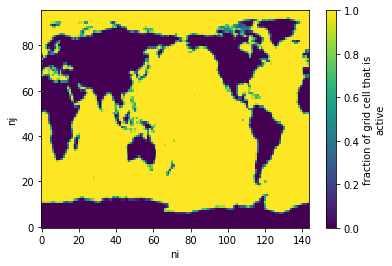

In [5]:
ocean_orig['frac'].plot.imshow()

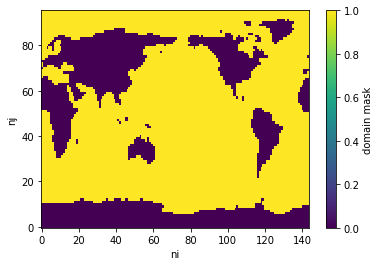

In [6]:
ocean_orig['mask'].plot.imshow()

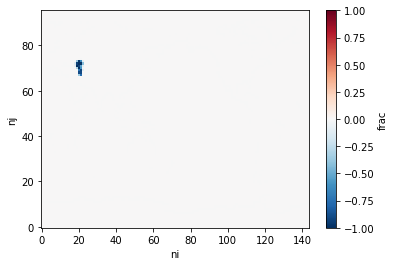

In [20]:
(ocean_orig['frac']-docn_orig['frac']).plot.imshow()

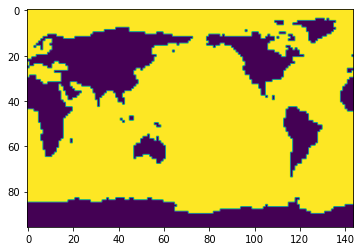

In [11]:
plt.imshow(np.array(ocean['frac']>0,dtype=int)[::-1])

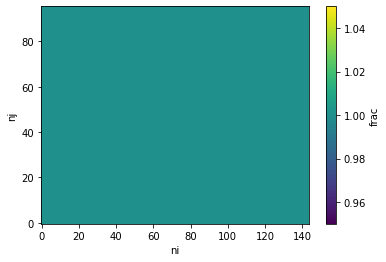

In [4]:
(land['frac']+ocean['frac']).plot.imshow()

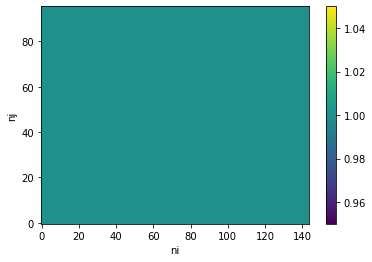

In [23]:
(land['frac']+docn['mask']).plot.imshow()

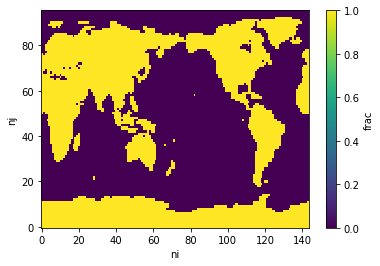

In [24]:
land['frac'].plot.imshow()

In [10]:
ocean['mask'].values.min()

0

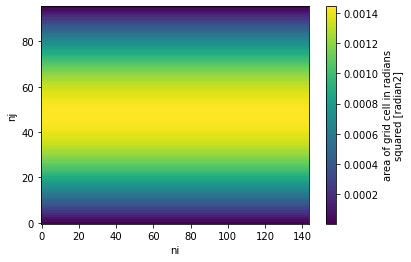

In [5]:
(land['area']).plot.imshow()

In [31]:
ocean['area'].values[0,1]

3.424304171951997e-05

In [30]:
(np.sin(land['xc'].values[0,1]*np.pi/180)-np.sin(land['xc'].values[0,0]*np.pi/180))*(land['yc'].values[1,0]-land['yc'].values[0,0])*np.pi**2/180**2

2.517579517624273e-05

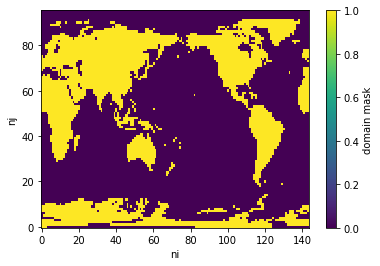

In [6]:
land['mask'].plot.imshow()

In [31]:
land['xc'].values

array([[  0. ,   2.5,   5. , ..., 352.5, 355. , 357.5],
       [  0. ,   2.5,   5. , ..., 352.5, 355. , 357.5],
       [  0. ,   2.5,   5. , ..., 352.5, 355. , 357.5],
       ...,
       [  0. ,   2.5,   5. , ..., 352.5, 355. , 357.5],
       [  0. ,   2.5,   5. , ..., 352.5, 355. , 357.5],
       [  0. ,   2.5,   5. , ..., 352.5, 355. , 357.5]])

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [11]:
ocntopo_file = '/data/bnb32/inputdata/oceanfrac_files/oceantopo_0Ma_f19_g16.ieeei4'
ocnmask_file = '/data/bnb32/inputdata/oceanfrac_files/oceanmask_0Ma_f19_g16.ieeei4'
orig_ocnmask = np.fromfile('/data/cesm/inputdata/ocn/pop/gx1v6/grid/region_mask_20090205.ieeei4',dtype='>i4')
ocntopo_data = np.fromfile(ocntopo_file,dtype='>i4')
ocnmask_data = np.fromfile(ocnmask_file,dtype='>i4')

In [12]:
horiz_data = np.fromfile('/data/cesm/inputdata/ocn/pop/gx1v6/grid/horiz_grid_20010402.ieeer8',dtype='double')
ts_data = np.fromfile('/data/cesm/inputdata/ocn/pop/gx1v6/ic/ts_PHC2_jan_ic_gx1v6_20090205.ieeer8',dtype='>f8')
#ts_data = xr.open_mfdataset('/data/cesm/inputdata/ocn/pop/gx1v6/ic/ecosys_jan_IC_omip_POP_gx1v7_c200323.nc')
initocn_data = np.fromfile('/data/bnb32/inputdata/oceanfrac_files/init_ocean_0Ma_f19_g16.ieeer8',dtype='>f8')
plant_data = xr.open_mfdataset('/data/bnb32/inputdata/landfrac_files/landplant_0Ma_f19_g16.nc')
initcam_data = xr.open_mfdataset('/data/cesm/inputdata/cesm2_init/b.e20.B1850.f19_g17.release_cesm2_1_0.020/0301-01-01/b.e20.B1850.f19_g17.release_cesm2_1_0.020.cam.i.0301-01-01-00000.nc')
solar_data = xr.open_mfdataset('/data/cesm/inputdata/atm/cam/solar/SolarForcingCMIP6piControl_c160921.nc')
long_data = xr.open_mfdataset('/data/cesm/inputdata/atm/waccm/phot/temp_prs_GT200nm_JPL10_c140624.nc')

In [6]:
tmp = xr.open_mfdataset('/data/cesm/inputdata/ocn/docn7/domain.ocn.1x1.111007.nc')

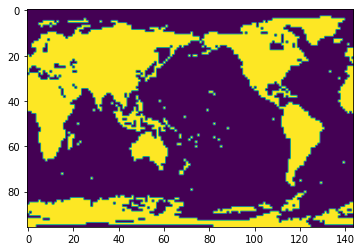

In [8]:
plt.imshow(np.array(plant_data['PFTDATA_MASK'].values>0)[::-1])

-17.704111166934375

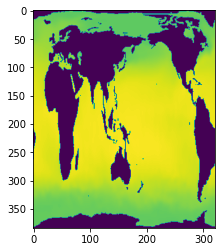

In [33]:
plt.imshow(ts_data[0,0,::-1,:])
ts_data[0,0,::-1,:].mean()

In [13]:
ocntopo_data = ocntopo_data.reshape(384,320)
ocnmask_data = ocnmask_data.reshape(384,320)
orig_ocnmask = orig_ocnmask.reshape(384,320)

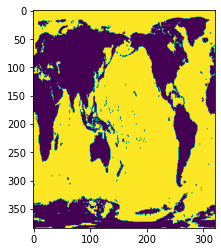

In [14]:
plt.imshow(np.array(ocnmask_data[::-1,:],dtype=float))

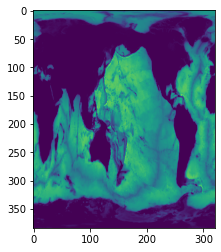

In [15]:
plt.imshow(ocntopo_data[::-1,:])

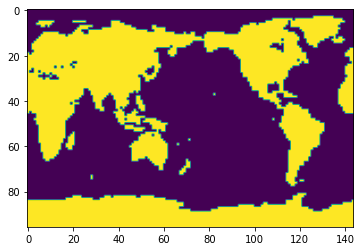

In [14]:
plt.imshow(land_orig['mask'][::-1,:])

In [5]:
f19_data = xr.open_mfdataset('/data/bnb32/inputdata/remapped_land_files/remapped_0Ma_f19.nc')
high_res = xr.open_mfdataset('/data/bnb32/inputdata/topo_files/high_res/0Ma_high_res.nc')

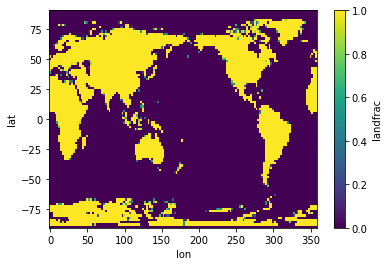

In [8]:
f19_data['landfrac'].plot.imshow()

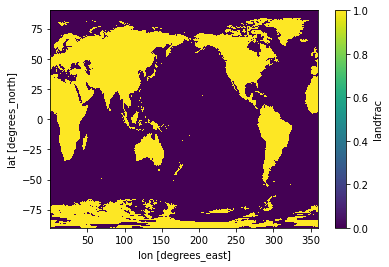

In [3]:
high_res['landfrac'].plot.imshow()

In [4]:
high_res['lat'].values

array([-90. , -89.9, -89.8, ...,  89.8,  89.9,  90. ])

In [2]:
atm_tmp = xr.open_mfdataset('/data/bnb32/scratch/archive/cam_clmCN_docnSOM_co2_1.0x_continents_0Ma_experiment/atm/hist/cam_clmCN_docnSOM_co2_1.0x_continents_0Ma_experiment.cam.h0.0001-01-01-00000.nc')

In [4]:
lnd_tmp = xr.open_mfdataset('/data/bnb32/scratch/archive/cam_clmCN_docnSOM_co2_1.0x_continents_0Ma_experiment/run/cam_clmCN_docnSOM_co2_1.0x_continents_0Ma_experiment.clm2.r.0001-01-04-00000.nc')

In [5]:
lnd_tmp

<xarray.Dataset>
Dimensions:                               (gridcell: 5663, landunit: 14842, column: 32430, levgrnd: 25, pft: 50430, glc_nec1: 11, levsno: 12, vegwcs: 4, levlak: 10, levcan: 1, numrad: 2, levtot: 37, levsno1: 13, ntapes: 1)
Dimensions without coordinates: gridcell, landunit, column, levgrnd, pft, glc_nec1, levsno, vegwcs, levlak, levcan, numrad, levtot, levsno1, ntapes
Data variables: (12/419)
    timemgr_rst_nstep_rad_prev            float64 ...
    timemgr_rst_type                      float64 ...
    timemgr_rst_step_sec                  float64 ...
    timemgr_rst_start_ymd                 float64 ...
    timemgr_rst_start_tod                 float64 ...
    timemgr_rst_ref_ymd                   float64 ...
    ...                                    ...
    soil4c                                (column) float64 dask.array<chunksize=(32430,), meta=np.ndarray>
    col_ctrunc                            (column) float64 dask.array<chunksize=(32430,), meta=np.ndarray>
    spinup_state                          float64 ...
    history_tape_in_use                   (ntapes) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    locfnh                                (ntapes) |S199 dask.array<chunksize=(1,), meta=np.ndarray>
    locfnhr                               (ntapes) |S199 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/118)
    Conventions:                               CF-1.0
    history:                                   created on 10/26/21 15:46:04
    username:                                  ec2-user
    host:                                      aws_c5
    version:                                   cesm2.2.0
    source:                                    Community Terrestrial Systems ...
    ...                                        ...
    ilun_deep_lake:                            5
    ilun_wetland:                              6
    ilun_urban_tbd:                            7
    ilun_urban_hd:                             8
    ilun_urban_md:                             9
    issue_fixed_783:                           1